In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import joblib


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Load datasets
dataset = pd.read_csv('dataset.csv')

symptom_precaution = pd.read_csv('symptom_precaution.csv')

# Load doctor versus disease mapping
doctor_vs_disease = pd.read_csv('Doctor_Versus_Disease.csv', encoding='ISO-8859-1')

# Check dataset columns
print("Columns in dataset:", dataset.columns)
print("Columns in dataset:", doctor_vs_disease.columns)
dataset.head()


Columns in dataset: Index(['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4',
       'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9',
       'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14',
       'Symptom_15', 'Symptom_16', 'Symptom_17'],
      dtype='object')
Columns in dataset: Index(['Drug Reaction', 'Allergist'], dtype='object')


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Get all unique symptoms across Symptom1, Symptom2, Symptom3,... columns
all_symptoms = pd.unique(dataset.drop('Disease', axis=1).values.ravel())
all_symptoms = [symptom for symptom in all_symptoms if pd.notnull(symptom)]

# Create new dataframe with one column per unique symptom, initialised to 0
multi_hot_df = pd.DataFrame(0, index=dataset.index, columns=all_symptoms)

# For each row, set present symptoms to 1
for idx, row in dataset.drop('Disease', axis=1).iterrows():
    for symptom in row:
        if pd.notnull(symptom):
            multi_hot_df.loc[idx, symptom] = 1

# Final input features and target
X = multi_hot_df
y = dataset['Disease']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Check feature sample
X.head()


NameError: name 'pd' is not defined

In [10]:
from sklearn.model_selection import train_test_split

# Split dataset into train (80%) and hold-out test (20%)
# X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(X_augmented, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_full, X_holdout, y_train_full, y_holdout = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


print("Train shape:", X_train_full.shape)
print("Hold-out test shape:", X_holdout.shape)


Train shape: (3936, 131)
Hold-out test shape: (984, 131)


In [11]:
import random

def randomly_remove_symptoms(row, num_remove=2):
    symptoms_present = row[row == 1].index.tolist()
    if len(symptoms_present) > num_remove:
        symptoms_to_remove = random.sample(symptoms_present, num_remove)
        row[symptoms_to_remove] = 0
    return row

# ✅ Apply augmentation
X_augmented = X.apply(randomly_remove_symptoms, axis=1)


In [ ]:
# Stratified K Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)




In [ ]:
from sklearn.utils import resample

majority_class = dataset['Disease'].value_counts().idxmax()
df_majority = dataset[dataset.Disease == majority_class]
df_minority = dataset[dataset.Disease != majority_class]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine and shuffle
dataset = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

# ✅ Step 2. Encode symptoms into one-hot vectors
all_symptoms = pd.unique(dataset.drop('Disease', axis=1).values.ravel())
all_symptoms = [s for s in all_symptoms if pd.notnull(s)]

def encode_symptoms(row):
    encoded = {symptom: 0 for symptom in all_symptoms}
    for symptom in row[1:]:
        if pd.notnull(symptom):
            encoded[symptom] = 1
    return pd.Series(encoded)

X = dataset.apply(encode_symptoms, axis=1)
y = dataset['Disease']


X_augmented = X.copy()

# Option 2: Limit removal to max 1 symptom for inputs with >=4 symptoms
def safe_remove(row, num_remove=1):
    symptoms_present = row[row == 1].index.tolist()
    if len(symptoms_present) > 3:
        symptoms_to_remove = random.sample(symptoms_present, min(num_remove, len(symptoms_present)-3))
        row[symptoms_to_remove] = 0
    return row

# X_augmented = X.apply(safe_remove, axis=1)
X_augmented = X.copy()



# ✅ Step 4. Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)




# Save label encoder for deployment
joblib.dump(le, 'label_encoder.pkl')

# ✅ Step 5. Define models
models = {
    'random_forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'decision_tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'logistic_regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'naive_bayes': GaussianNB(),
    'knn': KNeighborsClassifier()
}


# ✅ Step 6. 5-fold Stratified Cross Validation and Training
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    accuracies = []
    print(f"\n{name} Cross-Validation Results:")

    for train_idx, test_idx in skf.split(X_augmented, y_encoded):
        X_train, X_test = X_augmented.iloc[train_idx], X_augmented.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        accuracies.append(acc)

    avg_acc = np.mean(accuracies)
    print(f"Average Accuracy (5-fold): {avg_acc:.2%}")

    # Save each model (optional)
    joblib.dump(model, f"{name}_model.pkl")

# ✅ Step 7. Save Random Forest explicitly for Flask deployment
joblib.dump(models['random_forest'], 'random_forest_model.pkl')
print("\n✅ Random Forest model saved for deployment as 'random_forest_model.pkl'")



random_forest Cross-Validation Results:


c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Accuracy (5-fold): 98.33%

decision_tree Cross-Validation Results:
Average Accuracy (5-fold): 93.33%

logistic_regression Cross-Validation Results:


c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average Accuracy (5-fold): 98.33%

naive_bayes Cross-Validation Results:
Average Accuracy (5-fold): 98.33%

knn Cross-Validation Results:
Average Accuracy (5-fold): 81.25%


c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



✅ Random Forest model saved for deployment as 'random_forest_model.pkl'



random_forest Cross-Validation Results:


c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Fold 1 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]

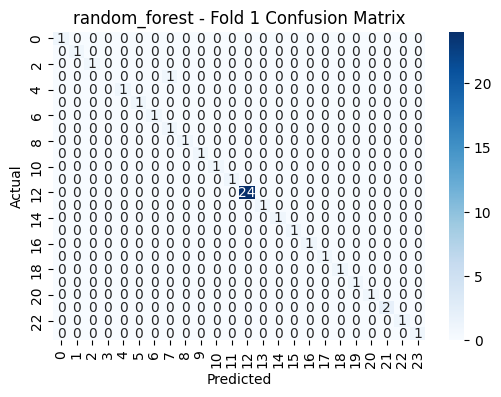


Fold 2 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 

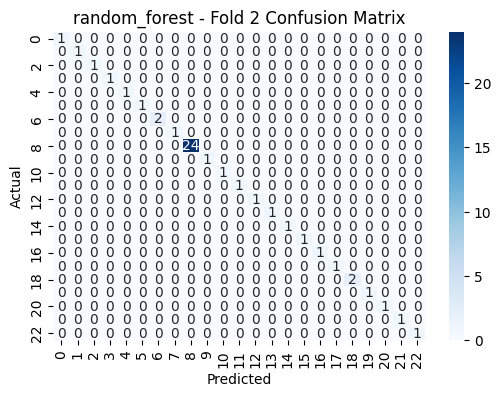


Fold 3 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]

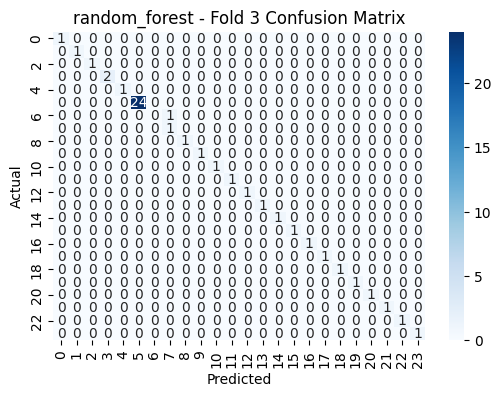


Fold 4 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

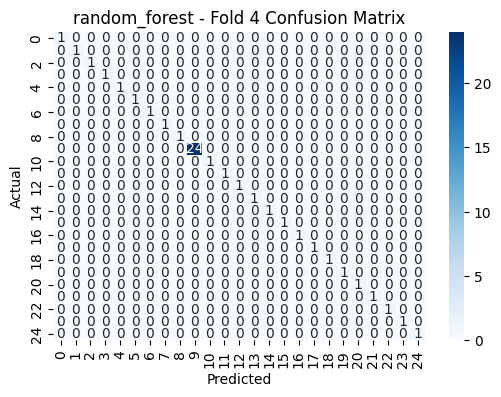


Fold 5 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0

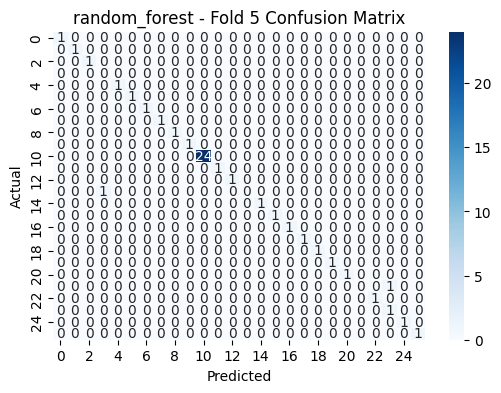


Average Accuracy (5-fold): 98.33%

decision_tree Cross-Validation Results:

Fold 1 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


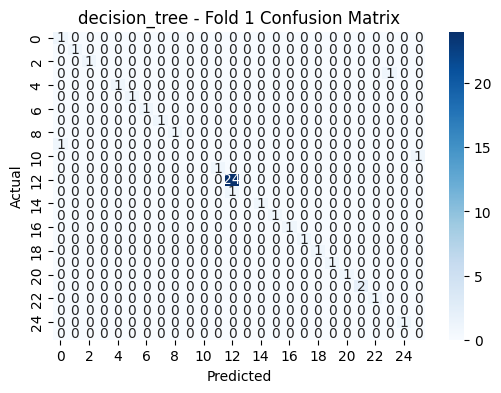


Fold 2 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]

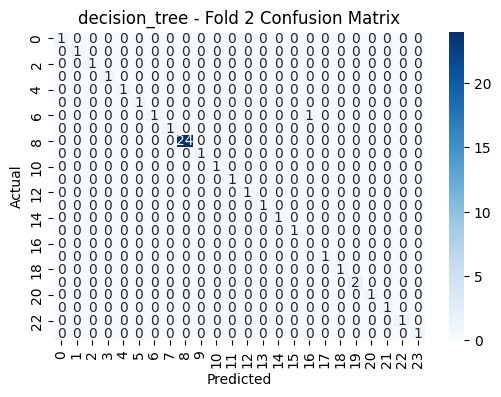


Fold 3 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]

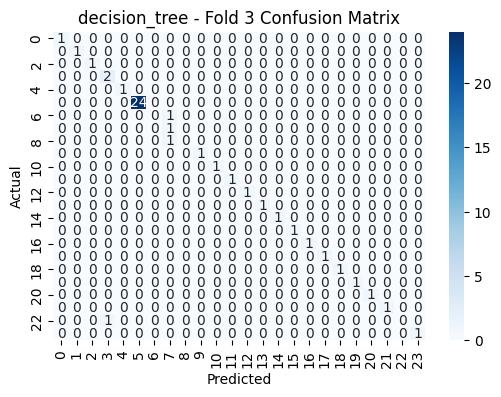


Fold 4 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

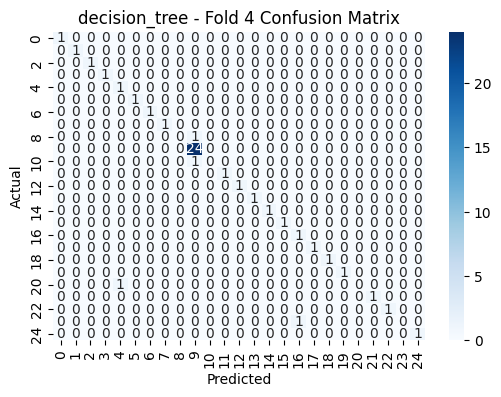


Fold 5 Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0

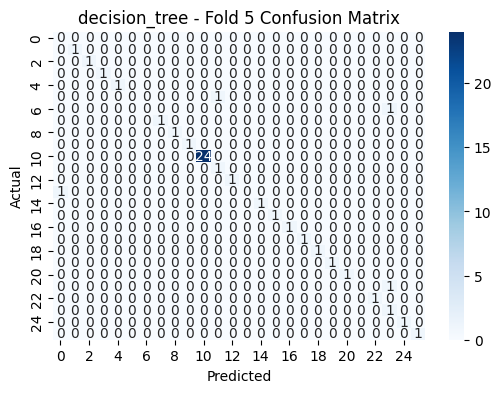


Average Accuracy (5-fold): 93.33%

logistic_regression Cross-Validation Results:

Fold 1 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0

c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


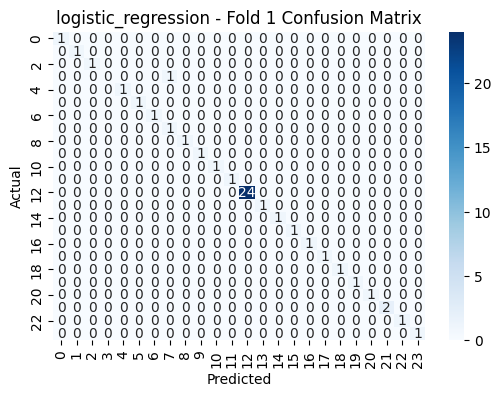


Fold 2 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 

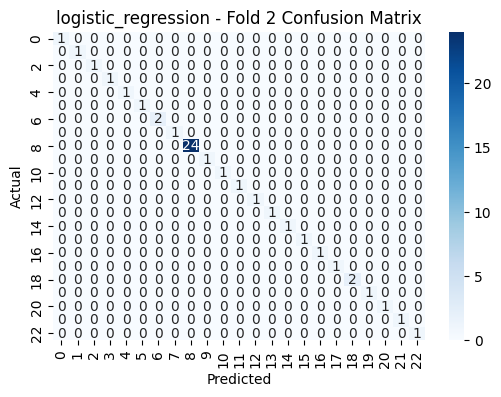


Fold 3 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]

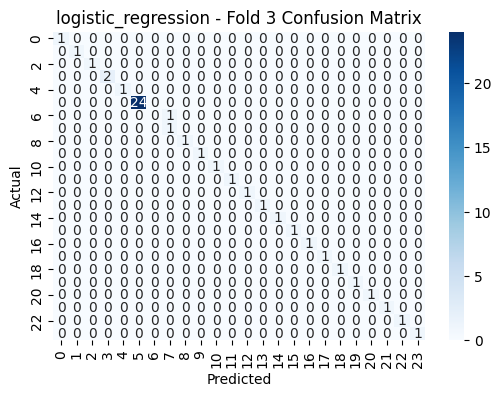


Fold 4 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

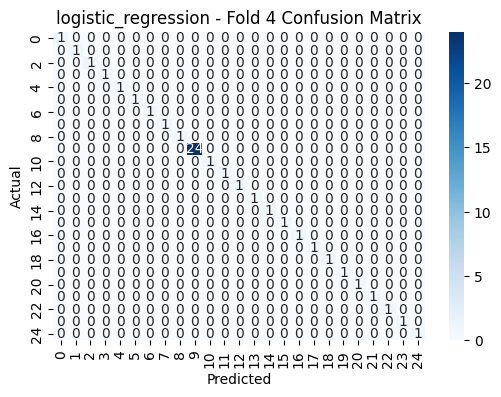


Fold 5 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0

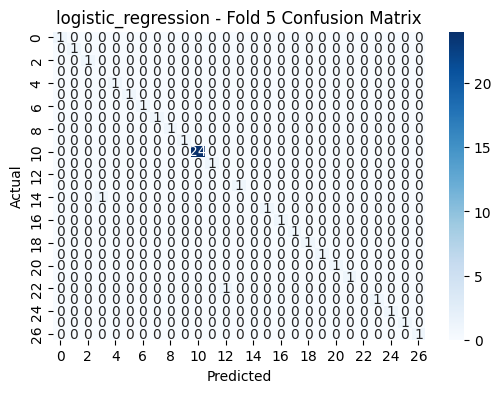


Average Accuracy (5-fold): 98.33%

naive_bayes Cross-Validation Results:

Fold 1 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]


c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


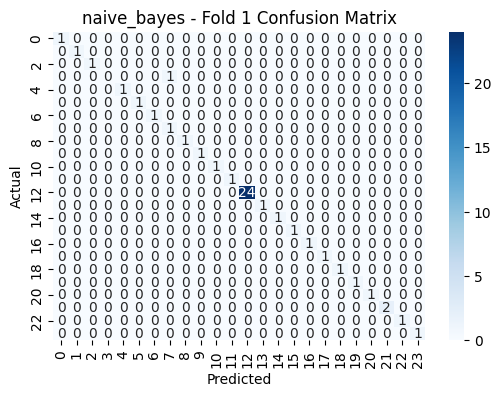


Fold 2 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 

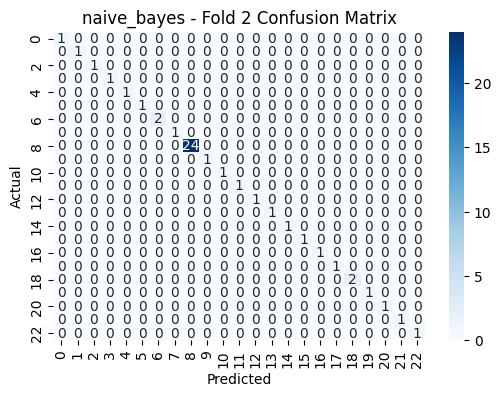


Fold 3 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]

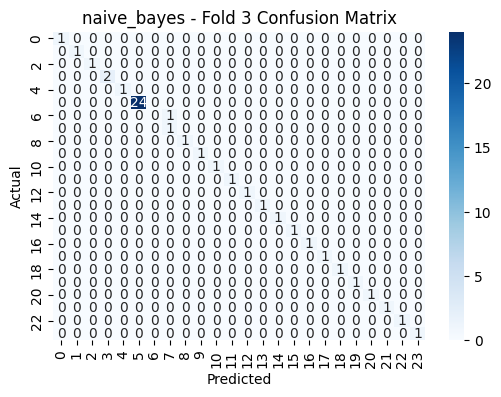


Fold 4 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

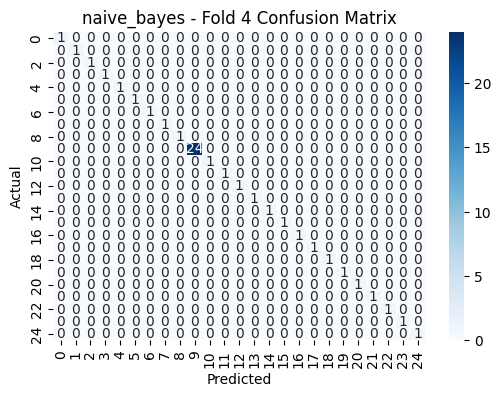


Fold 5 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

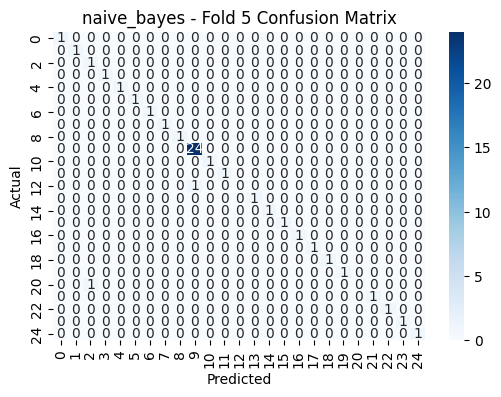


Average Accuracy (5-fold): 98.33%

knn Cross-Validation Results:

Fold 1 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  

c:\Users\E MAHITHA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


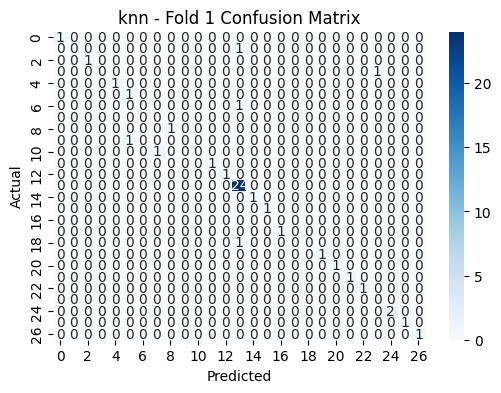


Fold 2 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 

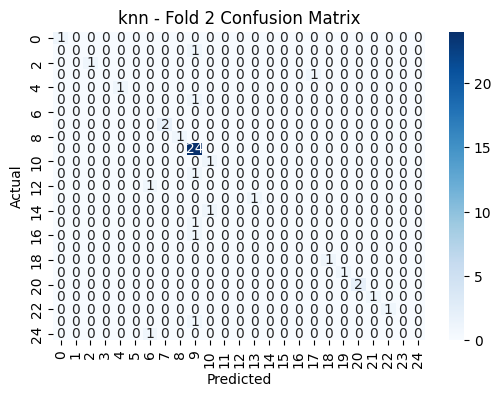


Fold 3 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0

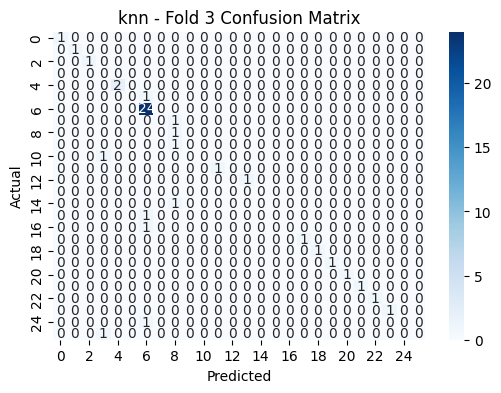


Fold 4 Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0

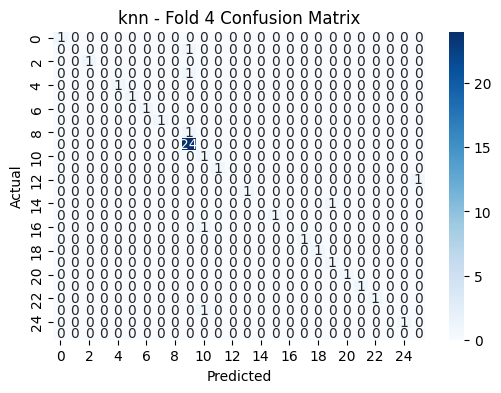


Fold 5 Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  

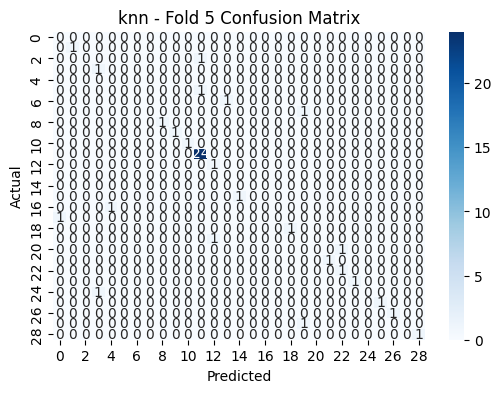


Average Accuracy (5-fold): 81.25%


In [14]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
for name, model in models.items():
    accuracies = []
    print(f"\n{name} Cross-Validation Results:")

    fold = 1
    for train_idx, test_idx in skf.split(X_augmented, y_encoded):
        X_train, X_test = X_augmented.iloc[train_idx], X_augmented.iloc[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # ✅ Confusion Matrix
        cm = confusion_matrix(y_test, preds)
        print(f"\nFold {fold} Confusion Matrix:\n{cm}")

        # ✅ Performance Metrics
        acc = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average='macro', zero_division=0)
        recall = recall_score(y_test, preds, average='macro', zero_division=0)
        f1 = f1_score(y_test, preds, average='macro', zero_division=0)

        print(f"Fold {fold} Accuracy: {acc:.2%}")
        print(f"Fold {fold} Precision: {precision:.2%}")
        print(f"Fold {fold} Recall: {recall:.2%}")
        print(f"Fold {fold} F1 Score: {f1:.2%}")

        accuracies.append(acc)
        fold += 1

        # ✅ Optional: Visualise Confusion Matrix per fold
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} - Fold {fold-1} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    avg_acc = np.mean(accuracies)
    print(f"\nAverage Accuracy (5-fold): {avg_acc:.2%}")

    # Save each model (optional)
    joblib.dump(model, f"{name}_model.pkl")


In [15]:
import pandas as pd
import joblib

# ✅ Load trained model and label encoder
loaded_rf = joblib.load("random_forest_model.pkl")
le = joblib.load("label_encoder.pkl")

# ✅ Get features directly from model to avoid mismatch
feature_columns = loaded_rf.feature_names_in_

# ✅ Load precaution and doctor mapping data
symptom_precaution = pd.read_csv('symptom_precaution.csv')
doctor_vs_disease = pd.read_csv('Doctor_Versus_Disease.csv', encoding='latin1')

# ✅ Clean column names for consistency
symptom_precaution.columns = symptom_precaution.columns.str.strip()
doctor_vs_disease.columns = doctor_vs_disease.columns.str.strip()

# ✅ Example: create manual test input for known symptoms
# Replace this list with symptoms you want to test
test_symptoms = ['itching', 'skin_rash']

# ✅ Create input_dict with ALL features initialized to 0
input_dict = {feature: 0 for feature in feature_columns}

# ✅ Update only selected symptoms to 1 (case-insensitive match)
model_features_cleaned = [f.strip().lower() for f in feature_columns]

for symptom in test_symptoms:
    clean_symptom = symptom.strip().lower()
    if clean_symptom in model_features_cleaned:
        index = model_features_cleaned.index(clean_symptom)
        actual_feature = feature_columns[index]
        input_dict[actual_feature] = 1

# ✅ Create DataFrame with columns in exact order as model
sample_input = pd.DataFrame([input_dict], columns=feature_columns)

# ✅ Debug print to confirm input shape matches model expectation
print("Input shape:", sample_input.shape)
print("Model expects:", len(feature_columns))

# ✅ Predict encoded disease label
predicted_encoded = loaded_rf.predict(sample_input)[0]

# ✅ Decode to actual disease name
predicted_disease = le.inverse_transform([predicted_encoded])[0]

print("\n✅ Predicted Disease:", predicted_disease)

# ✅ Recommend precautions based on predicted disease
precautions = symptom_precaution[symptom_precaution['Disease'] == predicted_disease]

if not precautions.empty:
    print("\nRecommended Precautions:")
    for col in precautions.columns[1:]:
        precaution_value = precautions[col].values[0]
        if pd.notnull(precaution_value):
            print(f"- {precaution_value}")
else:
    print("No precaution data found for this disease.")

# ✅ Recommend doctor based on predicted disease
doctor_row = doctor_vs_disease[doctor_vs_disease['Drug Reaction'] == predicted_disease]

if not doctor_row.empty:
    print("\nRecommended Doctor:")
    print(f"- {doctor_row.iloc[0, 1]}")  # prints the doctor column value
else:
    print("No doctor data found for this disease.")


Input shape: (1, 131)
Model expects: 131

✅ Predicted Disease: Fungal infection

Recommended Precautions:
- bath twice
- use detol or neem in bathing water
- keep infected area dry
- use clean cloths

Recommended Doctor:
- Dermatologist


In [16]:
# Save feature columns for deployment
joblib.dump(X_augmented.columns.tolist(), 'feature_columns.pkl')
print("✅ Feature columns saved for deployment.")


✅ Feature columns saved for deployment.
